In [2]:
#constants
DF_PATH = "../data/processed/1_preprocessed_df.pkl"


ROLE_COLS      = ['DevType']
TECH_COLS      = ['LanguageWorkedWith',    'DatabaseWorkedWith',    'WebframeWorkedWith',    'MiscTechWorkedWith',   ]
TECH_NEXT_COLS = ['LanguageDesireNextYear','DatabaseDesireNextYear','WebframeDesireNextYear','MiscTechDesireNextYear' ,]


In [30]:
# Load packages
import pandas as pd 
import numpy as np
import logging
import pickle

import plotly 
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.express as px
import plotly.figure_factory as ff
from matplotlib import pyplot as plt
import seaborn as sns

from sklearn.cluster import AgglomerativeClustering

from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
from sklearn.metrics import silhouette_score


import scipy.cluster.hierarchy as sch

# Read data and preprocess

In [4]:
#Read data
raw_df=pd.read_pickle(DF_PATH)
raw_df.head()

,Respondent,MainBranch,Hobbyist,Age,Age1stCode,CompFreq,CompTotal,ConvertedComp,Country,CurrencyDesc,...,SurveyEase,SurveyLength,Trans,UndergradMajor,WebframeDesireNextYear,WebframeWorkedWith,WelcomeChange,WorkWeekHrs,YearsCode,YearsCodePro
0,1,I am a developer by profession,Yes,NaN,13.0,Monthly,NaN,NaN,Germany,European Euro,...,Neither easy nor difficult,Appropriate in length,No,"Computer science, computer engineering, or sof...",[ASP.NET Core],"[ASP.NET, ASP.NET Core]",Just as welcome now as I felt last year,50.0,36.0,27.0
1,2,I am a developer by profession,No,NaN,19.0,NaN,NaN,NaN,United Kingdom,Pound sterling,...,NaN,NaN,NaN,"Computer science, computer engineering, or sof...",[],[],Somewhat more welcome now than last year,NaN,7.0,4.0
2,3,I code primarily as a hobby,Yes,NaN,15.0,NaN,NaN,NaN,Russian Federation,NaN,...,Neither easy nor difficult,Appropriate in length,NaN,NaN,[],[],Somewhat more welcome now than last year,NaN,4.0,NaN
3,4,I am a developer by profession,Yes,25.0,18.0,NaN,NaN,NaN,Albania,Albanian lek,...,NaN,NaN,No,"Computer science, computer engineering, or sof...",[],[],Somewhat less welcome now than last year,40.0,7.0,4.0
4,5,"I used to be a developer by profession, but no...",Yes,31.0,16.0,NaN,NaN,NaN,United States,NaN,...,Easy,Too short,No,"Computer science, computer engineering, or sof...","[Django, Ruby on Rails]",[Ruby on Rails],Just as welcome now as I felt last year,NaN,15.0,8.0


# one hot encoded

In [5]:
df=raw_df.copy()
encoded_dfs={}
for col in ROLE_COLS +TECH_COLS :
    binarizer=MultiLabelBinarizer()
    encoded_df=pd.DataFrame(binarizer.fit_transform(df[col]) ,columns=binarizer.classes_ , index=df[col].index)
    encoded_dfs[col]=encoded_df
    

In [6]:
ohe_df=pd.concat(encoded_dfs ,axis=1)
ohe_df

DevType                           \
      Academic researcher Data or business analyst   
0                       0                        0   
1                       0                        0   
2                       0                        0   
3                       0                        0   
4                       0                        0   
...                   ...                      ...   
64456                   0                        0   
64457                   0                        0   
64458                   0                        0   
64459                   0                        0   
64460                   0                        0   

                                                                            \
      Data scientist or machine learning specialist Database administrator   
0                                                 0                      0   
1                                                 0                      0   
2                                                 0                      0   
3                                                 0                      0   
4                                                 0                      0   
...                                             ...                    ...   
64456                                             0                      0   
64457                                             0                      0   
64458                                             0                      0   
64459                                             0                      0   
64460                                             0                      0   

                                                                            \
      Designer DevOps specialist Developer, QA or test Developer, back-end   
0            0                 0                     0                   0   
1            0                 0                     0                   0   
2            0                 0                     0                   0   
3            0                 0                     0                   0   
4            0                 0                     0                   0   
...        ...               ...                   ...                 ...   
64456        0                 0                     0                   0   
64457        0                 0                     0                   0   
64458        0                 0                     0                   0   
64459        0                 0                     0                   0   
64460        0                 0                     0                   0   

                                                     \
      Developer, desktop or enterprise applications   
0                                                 1   
1                                                 0   
2                                                 0   
3                                                 0   
4                                                 0   
...                                             ...   
64456                                             0   
64457                                             0   
64458                                             0   
64459                                             0   
64460                                             0   

                                                   ... MiscTechWorkedWith  \
      Developer, embedded applications or devices  ...            Node.js   
0                                               0  ...                  0   
1                                               0  ...                  0   
2                                               0  ...                  0   
3                                               0  ...                  0   
4                                               0  ...                  0   
...                           

# Dimensionality reduction


In [7]:
# Prepare sub data frames 
skills_ohe = ohe_df.drop('DevType', axis=1).copy()
std_skills = StandardScaler().fit_transform(skills_ohe)
std_skills_df=pd.DataFrame(std_skills ,columns= skills_ohe.columns)

In [8]:
std_skills_df

LanguageWorkedWith                                                      \
                Assembly Bash/Shell/PowerShell         C        C#       C++   
0              -0.241524             -0.646001 -0.490158  1.604066 -0.519680   
1              -0.241524             -0.646001 -0.490158 -0.623416 -0.519680   
2              -0.241524             -0.646001 -0.490158 -0.623416 -0.519680   
3              -0.241524             -0.646001 -0.490158 -0.623416 -0.519680   
4              -0.241524             -0.646001 -0.490158 -0.623416 -0.519680   
...                  ...                   ...       ...       ...       ...   
64456          -0.241524             -0.646001 -0.490158 -0.623416 -0.519680   
64457           4.140374              1.547986  2.040159  1.604066  1.924261   
64458          -0.241524             -0.646001 -0.490158 -0.623416 -0.519680   
64459          -0.241524             -0.646001 -0.490158 -0.623416 -0.519680   
64460          -0.241524             -0.646001 -0.490158  1.604066 -0.519680   

                                                         ...  \
           Dart        Go  HTML/CSS   Haskell      Java  ...   
0     -0.191487 -0.291173  0.884096 -0.139009 -0.746671  ...   
1     -0.191487 -0.291173 -1.131099 -0.139009 -0.746671  ...   
2     -0.191487 -0.291173 -1.131099 -0.139009 -0.746671  ...   
3     -0.191487 -0.291173 -1.131099 -0.139009 -0.746671  ...   
4     -0.191487 -0.291173  0.884096 -0.139009 -0.746671  ...   
...         ...       ...       ...       ...       ...  ...   
64456 -0.191487 -0.291173 -1.131099 -0.139009 -0.746671  ...   
64457  5.222295  3.434379  0.884096  7.193776  1.339277  ...   
64458 -0.191487 -0.291173 -1.131099 -0.139009 -0.746671  ...   
64459 -0.191487 -0.291173  0.884096 -0.139009 -0.746671  ...   
64460 -0.191487 -0.291173  0.884096 -0.139009  1.339277  ...   

      MiscTechWorkedWith                                              \
                 Node.js    Pandas    Puppet React Native TensorFlow   
0              -0.688771 -0.327758 -0.121976    -0.278051  -0.278892   
1              -0.688771 -0.327758 -0.121976     3.596457  -0.278892   
2              -0.688771 -0.327758 -0.121976    -0.278051  -0.278892   
3              -0.688771 -0.327758 -0.121976    -0.278051  -0.278892   
4              -0.688771 -0.327758 -0.121976    -0.278051  -0.278892   
...                  ...       ...       ...          ...        ...   
64456          -0.688771 -0.327758 -0.121976    -0.278051  -0.278892   
64457          -0.688771 -0.327758 -0.121976    -0.278051  -0.278892   
64458          -0.688771 -0.327758 -0.121976    -0.278051  -0.278892   
64459          -0.688771 -0.327758 -0.121976    -0.278051  -0.278892   
64460          -0.688771 -0.327758 -0.121976    -0.278051  -0.278892   

                                                                 
       Teraform Torch/PyTorch  Unity 3D Unreal Engine   Xamarin  
0     -0.201619     -0.172943 -0.271093     -0.144364 -0.194814  
1     -0.201619     -0.172943 -0.271093     -0.144364 -0.194814  
2     -0.201619     -0.172943 -0.271093     -0.144364 -0.194814  
3     -0.201619     -0.172943 -0.271093     -0.144364 -0.194814  
4     -0.201619     -0.172943 -0.271093     -0.144364 -0.194814  
...         ...           ...       ...           ...       ...  
64456 -0.201619     -0.172943 -0.271093     -0.144364 -0.194814  
64457 -0.201619     -0.172943 -0.271093     -0.144364 -0.194814  
64458 -0.201619     -0.172943 -0.271093     -0.144364 -0.194814  
64459 -0.201619     -0.172943 -0.271093     -0.144364 -0.194814  
64460 -0.201619     -0.172943 -0.271093     -0.144364 -0.194814  

[64461 rows x 74 columns]

In [20]:
tsne_projection = TSNE(n_components=2, 
                       perplexity=2.5, 
                       learning_rate=1, 
                       init='pca', 
                       method='barnes_hut', 
                       n_jobs=2, 
                       n_iter=10**4, 
                       random_state=0).fit_transform(std_skills.T)

tsne_projection = pd.DataFrame(tsne_projection, index=skills_ohe.columns)

In [21]:
tsne_projection

0          1
LanguageWorkedWith Assembly                -7.812083 -65.187965
                   Bash/Shell/PowerShell  -68.457191 -46.878925
                   C                       -3.294933 -65.579109
                   C#                     139.606354 -72.178185
                   C++                     -0.100805 -66.246559
...                                              ...        ...
MiscTechWorkedWith Teraform               -73.140190   6.850766
                   Torch/PyTorch          -75.024590 -75.455231
                   Unity 3D                24.588087 -76.467590
                   Unreal Engine           21.418337 -75.834671
                   Xamarin                143.424011 -80.413727

[74 rows x 2 columns]

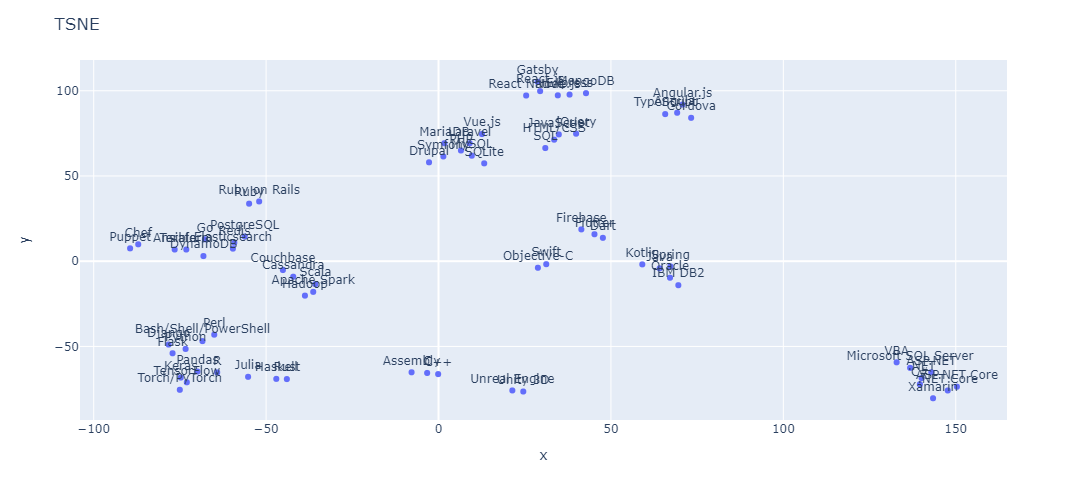

In [24]:
fig = px.scatter(x=tsne_projection[0], y=tsne_projection[1], text=tsne_projection.droplevel(0).index)
fig.update_traces(textposition='top center')
fig.update_layout(height=500, width=800, title_text='TSNE')
fig.show()

# clustering

In [37]:
range_n_cluster = list(range(5,25))
silhoutte_score = []
best_cluster_model = None 

for n_clusters in range_n_cluster :
     cluster_model=AgglomerativeClustering(n_clusters=n_clusters ,linkage='ward') 
     cluster_labels=cluster_model.fit_predict(tsne_projection)
     
     silhoutte_avg=silhouette_score(tsne_projection,cluster_labels)
     silhoutte_score+=[silhoutte_avg]    
     
     if silhoutte_avg >= np.max(silhoutte_score) :
        best_cluster_model=cluster_model
        

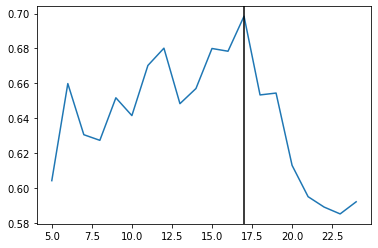

In [41]:
plt.plot(range_n_cluster, silhoutte_score)
plt.axvline(best_cluster_model.n_clusters, color='black')

In [46]:
cluster_labels = ["skills_group_" + str(label) 
                 for label in best_cluster_model.labels_]


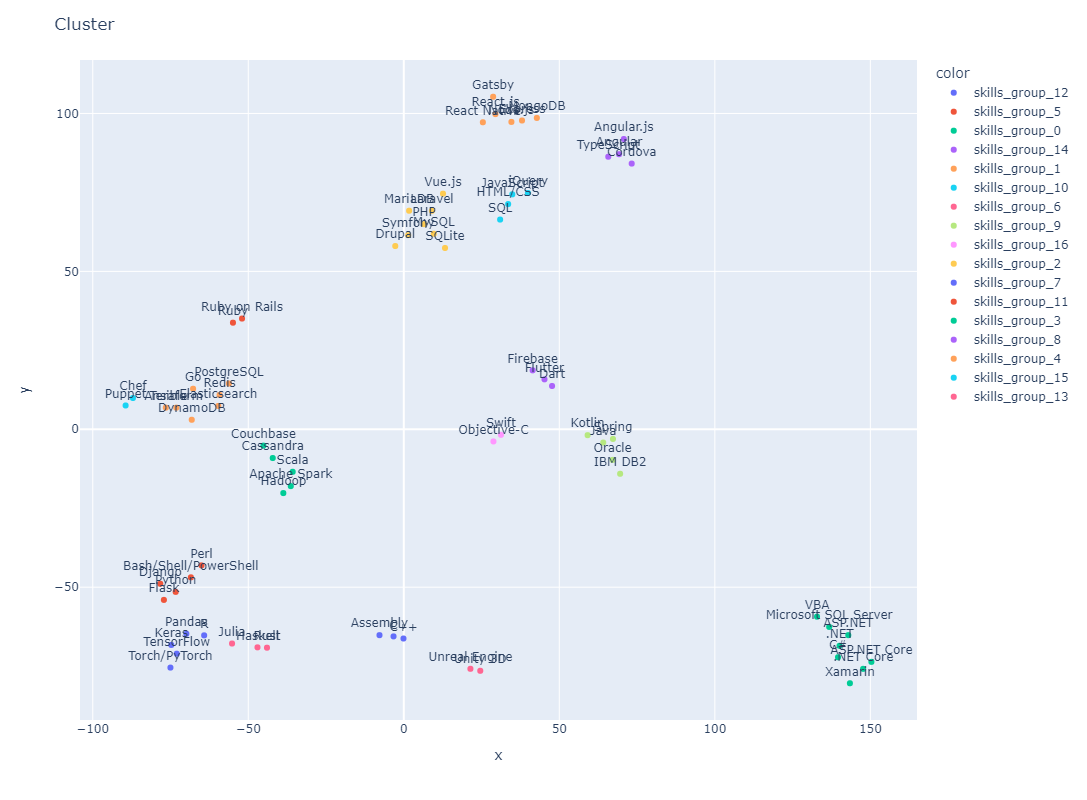

In [47]:
fig = px.scatter(x=tsne_projection[0], 
                 y=tsne_projection[1], 
                 text=tsne_projection.droplevel(0).index, 
                 color=cluster_labels)
fig.update_traces(textposition='top center')
fig.update_layout(height=800, width=800, title_text='Cluster')
fig.show()

In [48]:
# How to better write this
skills_clusters = tsne_projection.index.droplevel(0).to_series().groupby(cluster_labels).apply(list)

In [49]:
skills_clusters

skills_group_0     [C#, VBA, Microsoft SQL Server, ASP.NET, ASP.N...
skills_group_1     [Go, DynamoDB, Elasticsearch, PostgreSQL, Redi...
skills_group_10                  [HTML/CSS, JavaScript, SQL, jQuery]
skills_group_11                                [Ruby, Ruby on Rails]
skills_group_12                                   [Assembly, C, C++]
skills_group_13                            [Unity 3D, Unreal Engine]
skills_group_14                            [Dart, Firebase, Flutter]
skills_group_15                                       [Chef, Puppet]
skills_group_16                                 [Objective-C, Swift]
skills_group_2     [PHP, MariaDB, MySQL, SQLite, Drupal, Laravel,...
skills_group_3     [Scala, Cassandra, Couchbase, Apache Spark, Ha...
skills_group_4     [MongoDB, Express, Gatsby, React.js, Node.js, ...
skills_group_5     [Bash/Shell/PowerShell, Perl, Python, Django, ...
skills_group_6                                [Haskell, Julia, Rust]
skills_group_7         [R, Keras, 

In [50]:
for cluster, skills in skills_clusters.items():
    print(cluster)
    print(skills)

skills_group_0
['C#', 'VBA', 'Microsoft SQL Server', 'ASP.NET', 'ASP.NET Core', '.NET', '.NET Core', 'Xamarin']
skills_group_1
['Go', 'DynamoDB', 'Elasticsearch', 'PostgreSQL', 'Redis', 'Ansible', 'Teraform']
skills_group_10
['HTML/CSS', 'JavaScript', 'SQL', 'jQuery']
skills_group_11
['Ruby', 'Ruby on Rails']
skills_group_12
['Assembly', 'C', 'C++']
skills_group_13
['Unity 3D', 'Unreal Engine']
skills_group_14
['Dart', 'Firebase', 'Flutter']
skills_group_15
['Chef', 'Puppet']
skills_group_16
['Objective-C', 'Swift']
skills_group_2
['PHP', 'MariaDB', 'MySQL', 'SQLite', 'Drupal', 'Laravel', 'Symfony', 'Vue.js']
skills_group_3
['Scala', 'Cassandra', 'Couchbase', 'Apache Spark', 'Hadoop']
skills_group_4
['MongoDB', 'Express', 'Gatsby', 'React.js', 'Node.js', 'React Native']
skills_group_5
['Bash/Shell/PowerShell', 'Perl', 'Python', 'Django', 'Flask']
skills_group_6
['Haskell', 'Julia', 'Rust']
skills_group_7
['R', 'Keras', 'Pandas', 'TensorFlow', 'Torch/PyTorch']
skills_group_8
['TypeScrip

# Create Features

In [51]:
new_features = []

for cluster, skills in skills_clusters.items():
    cluster_sum = skills_ohe.droplevel(0, axis=1)[skills].sum(axis=1)
    cluster_sum.name = cluster
    new_features.append(cluster_sum)

fe_clustered_skills = pd.concat(new_features, axis=1)

In [54]:
fe_clustered_skills

,skills_group_0,skills_group_1,skills_group_10,skills_group_11,skills_group_12,skills_group_13,skills_group_14,skills_group_15,skills_group_16,skills_group_2,skills_group_3,skills_group_4,skills_group_5,skills_group_6,skills_group_7,skills_group_8,skills_group_9
0,6,1,2,0,0,0,0,0,0,0,0,0,0,0,0,0,1
1,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0
2,0,0,0,0,0,0,0,0,2,0,0,0,1,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,3,2,2,0,0,0,0,0,2,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
64456,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
64457,3,5,3,1,3,0,2,0,2,4,3,1,3,3,1,1,4
64458,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
64459,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1


In [57]:
class_weights = (1 / ohe_df['DevType'].sum(axis=0))
sample_weight = np.multiply(class_weights.values, 
                            ohe_df['DevType'].values).mean(axis=1)


array([5.29248642e-06, 6.18823226e-06, 0.00000000e+00, ...,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00])